# Analyze Presence of Third Party Trackers across First Parties

After identifying tracking related HTTP requests, we analyzed the results. Therefore, we checked additionally whether we could identify tracking domains in non-tracking related HTTP requests. We visualized the results of the tracking analysis.

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import Results from Tracking Identification

In [2]:
import pandas as pd

##import results of tracking identification
ad_tracking_df = pd.read_csv('/content/drive/My Drive/IT_Security/Code and Data/ad_tracking_df_full.csv')
non_ad_tracking_df = pd.read_csv('/content/drive/My Drive/IT_Security/Code and Data/non_ad_tracking_df_second_try.csv')

print(len(ad_tracking_df))
print(len(non_ad_tracking_df))

63024
57602


In [3]:
#adding column for tracking context
ad_tracking_df['tracking_context'] = "ad"
non_ad_tracking_df['tracking_context'] = "non_ad"

print(ad_tracking_df[:5], "\n")
print(non_ad_tracking_df[:5])

   visit_id  ... tracking_context
0         1  ...               ad
1         1  ...               ad
2         5  ...               ad
3         5  ...               ad
4         5  ...               ad

[5 rows x 5 columns] 

   visit_id  ... tracking_context
0         3  ...           non_ad
1         5  ...           non_ad
2         5  ...           non_ad
3         5  ...           non_ad
4         1  ...           non_ad

[5 rows x 5 columns]


In [4]:
#combine both dataframes to single tracking dataframe
tracking_df = pd.concat([ad_tracking_df, non_ad_tracking_df])

print(tracking_df[:5])
print(len(tracking_df))
print(len(set(tracking_df.visit_id)))

   visit_id  ... tracking_context
0         1  ...               ad
1         1  ...               ad
2         5  ...               ad
3         5  ...               ad
4         5  ...               ad

[5 rows x 5 columns]
120626
7641


In [0]:
#saving complete dataframe
tracking_df.to_csv('tracking_df.csv')

## Check for Presence of Third Parties

### Import List of Tracking Domains

In [6]:
#import package for regular expressions
import re

#read tracking host file
tracking_host_list = open(r"/content/drive/My Drive/IT_Security/Code and Data/tracking_host_list.csv", encoding = "ISO-8859-1")
#tracking_host_list = open(r"tracking_lists/tracking_host_list.csv", encoding = "ISO-8859-1")

#read lines in file
tracking_host_list = tracking_host_list.readlines()

#remove line break operators
tracking_host_list = [re.sub(r'\n', '', x) for x in tracking_host_list]

#to prevent not iterable error
tracking_host_list = [str(i) for i in tracking_host_list]

print(tracking_host_list[:10])
print(len(tracking_host_list))

['google-analytics.com', 'gstatic.com', 'google.com', 'fonts.googleapis.com', 'googletagmanager.com', 'doubleclick.net', 'facebook.net', 'googletagservices.com', 'facebook.com', 'googleadservices.com']
2183


In [7]:
#check whether tracking domain is in a http request url
def check_result(substr_ls, url_ls):
    
    result_url = list()
    tracking_call_list = list()
    
    #select url to check
    for url in url_ls:
        for substr in substr_ls:
            if substr in url:
                result_url.append(url)
                tracking_call_list.append(substr)
                break

    result_df = pd.DataFrame({'tracking_url': result_url,
                              'host_domain': tracking_call_list})
                
    return result_df
                
tracking_hosts_df = check_result(tracking_host_list, list(tracking_df.url))


print(tracking_hosts_df.head())
print(len(tracking_hosts_df))
print(len(tracking_df))
print(set(tracking_hosts_df.host_domain))

                                        tracking_url      host_domain
0  https://securepubads.g.doubleclick.net/tag/js/...  doubleclick.net
1  https://securepubads.g.doubleclick.net/gpt/pub...  doubleclick.net
2  https://securepubads.g.doubleclick.net/gpt/pub...  doubleclick.net
3  https://securepubads.g.doubleclick.net/gampad/...  doubleclick.net
4  https://securepubads.g.doubleclick.net/gpt/pub...  doubleclick.net
120626
120626
{'', 'adtech.de', 'recognified.net', 'ebay.de', 'retailrocket.net', 'twitter.com', 'ioam.de', 'exactag.com', 'univide.com', 'adnet.de', 'branch.io', 'ebaystatic.com', 'shopify.com', 'spotify.com', 'outbrainimg.com', 'adikteev.com', 'facebook.com', 'rambler.ru', 'googlesyndication.com', 'zemanta.com', 'zdbb.net', 'stylight.net', 'g2crowd.com', 'bitmedia.io', 'salesmanago.pl', 'sharethis.com', 'postrelease.com', 'rvty.net', 'pinterest.com', 'connectad.io', 'chartbeat.net', 'jsdelivr.net', 'curalate.com', 'lqm.io', 'creative-serving.com', 'pepper.com', 'brandwire

In [8]:
#merge together dataframes
if(len(tracking_df) == len(tracking_hosts_df)):
    tracking_df['host_domain'] = list(tracking_hosts_df['host_domain'])
    print(tracking_df[:5])
else:
    print('unequal length of dataframes')
    print(len(tracking_df))
    print(len(tracking_hosts_df))

   visit_id  ... tracking_context
0         1  ...               ad
1         1  ...               ad
2         5  ...               ad
3         5  ...               ad
4         5  ...               ad

[5 rows x 5 columns]


## Identify Occurrence of Trackers per Website

In [9]:
#create list of unique visit ids that have to be analyzed
visit_id_set_list = list(set(tracking_df.visit_id))
#print(visit_id_set_list)
print("number of first party domains:", len(visit_id_set_list))

#create empty list to store final results
result_list = [[], []]

number of first party domains: 7641


In [0]:
#identify tracking domains for each unique visit_id
for v_id in visit_id_set_list:
    
    #filter dataframe according to visit_id
    filtered_df = tracking_df[tracking_df.visit_id == v_id]
    
    #extract set of tracking host domains from filtered list
    tracking_domains = list(set(filtered_df.host_domain))
    
    #add visit_id to result_list
    result_list[0].append(v_id)

    #add identified tracking host domains to result_list
    result_list[1].append(tracking_domains)
    
#result_list

In [11]:
print(len(result_list[1]))

7641


## Analyze Occurrence of Tracking Domains Across Tracking HTTP Requests

In [12]:
#find out how often a tracking host domain occurs
import itertools

#combine list of trackers per website into single list of trackers
concat_domain_list = list(itertools.chain.from_iterable(result_list[1]))
concat_domain_list[:5]

['licdn.com',
 'doubleclick.net',
 'bing.com',
 'scorecardresearch.com',
 'ioam.de']

In [13]:
#convert to dataframe
concat_domain_df = pd.DataFrame(concat_domain_list)
concat_domain_df.columns = ['tracking_host_domain']
concat_domain_df[:5]

,tracking_host_domain
0,licdn.com
1,doubleclick.net
2,bing.com
3,scorecardresearch.com
4,ioam.de


In [14]:
#count occurrences of third party host domains
domain_counts = concat_domain_df['tracking_host_domain'].value_counts().rename_axis('domain').reset_index(name='counts')
domain_counts[:5]

,domain,counts
0,google-analytics.com,5510
1,doubleclick.net,4723
2,,2866
3,googletagmanager.com,2691
4,google.com,2381


In [15]:
#calculate percentage of occurrence of third party trackers on first party domains
#9281 = number of successfully crawled websites
domain_counts['occ_percentage'] = domain_counts['counts']/9281

print(len(visit_id_set_list))

domain_counts_tracking_identified = domain_counts

print(domain_counts[:5])

7641
                 domain  counts  occ_percentage
0  google-analytics.com    5510        0.593686
1       doubleclick.net    4723        0.508889
2                          2866        0.308803
3  googletagmanager.com    2691        0.289947
4            google.com    2381        0.256546


### Plot Results of Tracking Presence Across URLs where Tracking was Identified

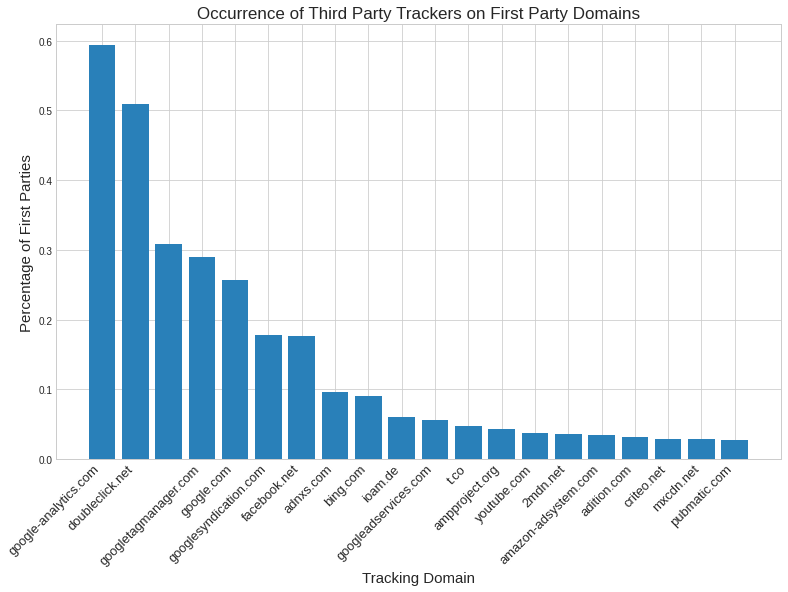

In [16]:
#plot results of overall tracking presence
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')

x = domain_counts.domain[:20]
y = domain_counts.occ_percentage[:20]

x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize = (13,8))
plt.bar(x_pos, y, color = '#2980b9')
plt.xlabel("Tracking Domain", fontsize = 15)
plt.ylabel("Percentage of First Parties", fontsize = 15)
plt.title("Occurrence of Third Party Trackers on First Party Domains", fontsize = 17)

plt.xticks(x_pos, x, rotation=45, fontsize = 13, ha = "right")

plt.show()

## Analyze Occurrence of Tracking Domains Across All (Tracking and non-Tracking) HTTP Requests

In [0]:
#import full http request data
http_requests = pd.read_csv("/content/drive/My Drive/IT_Security/Code and Data/http_requests.csv")
http_requests.head()

#import tracking host domain list
import re

#read tracking host file
tracking_host_list = open(r"/content/drive/My Drive/IT_Security/Code and Data/tracking_host_list.csv", encoding = "ISO-8859-1")

#read lines in file
tracking_host_list = tracking_host_list.readlines()

#remove line break operators
tracking_host_list = [re.sub(r'\n', '', x) for x in tracking_host_list]

#to prevent not iterable error
tracking_host_list = [str(i) for i in tracking_host_list]

In [18]:
#number of unique visit ids
len(set(http_requests.visit_id))

10002

In [19]:
#dimensions of http request data
print(len(http_requests))
print(len(tracking_df))

855804
120626


### Identify Occurrences of Tracking Host Domains

In [20]:
#check for presence of tracking host domains in http requests
def check_result(substr_ls, url_ls):
    
    result_url = list()
    tracking_call_list = list()
    
    #select url to check
    for url in url_ls:
        for substr in substr_ls:
            if substr in url:
                result_url.append(url)
                tracking_call_list.append(substr)
                break

    result_df = pd.DataFrame({'tracking_url': result_url,
                              'host_domain': tracking_call_list})
                
    return result_df

#apply function to all http request urls             
tracking_hosts_df = check_result(tracking_host_list, list(http_requests.url))

print(tracking_hosts_df.head())
print(len(tracking_hosts_df))
print(len(http_requests))
print(set(tracking_hosts_df.host_domain))

                   tracking_url host_domain
0               http://bahn.de/            
1       http://deref-web-02.de/            
2  http://immobilienscout24.de/            
3                http://dhl.de/            
4            http://linguee.de/            
855804
855804
{'', 'adtech.de', 'recognified.net', 'ebay.de', 'xing.com', 'photorank.me', 'retailrocket.net', 'twitter.com', 'ioam.de', 'cxpublic.com', 'exactag.com', 'univide.com', 'branch.io', 'adnet.de', 'ebaystatic.com', 'optmstr.com', 'contentpass.net', 'shopify.com', 'spotify.com', 'scarabresearch.com', 'kaspersky-labs.com', 'opinionbar.com', 'outbrainimg.com', 'rambler.ru', 'facebook.com', 'adikteev.com', 'quantcount.com', 'googlesyndication.com', 'zemanta.com', 'ekomi.de', 'monetate.net', 'zdbb.net', 'disquscdn.com', 'zencdn.net', 'stylight.net', 'g2crowd.com', 'sharethrough.com', 'adriver.ru', 'audiencemanager.de', 'bitmedia.io', 'here.com', 'rfihub.net', 'ktxtr.com', 'salesmanago.pl', 'datatables.net', 'glomex.cloud'

In [21]:
#merge together dataframes with http request and corresponding tracking domain
if(len(http_requests) == len(tracking_hosts_df)):
    http_requests['host_domain'] = list(tracking_hosts_df['host_domain'])
    print(http_requests[:5])
else:
    print('unequal length of dataframes')
    print(len(tracking_df))
    print(len(tracking_hosts_df))

   visit_id  ... host_domain
0         2  ...            
1         4  ...            
2         1  ...            
3         3  ...            
4         5  ...            

[5 rows x 4 columns]


### Analyze Presence of Tracking Domains Across Websites

In [22]:
#create list of unique visit ids that have to be analyzed
visit_id_set_list = list(set(http_requests.visit_id))
print(visit_id_set_list)
print("number of first party domains:", len(visit_id_set_list))

#create empty list to store final results
result_list = [[], []]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [0]:
#search for tracking host domains in all http requests
#identify tracking domains for each unique visit_id
for v_id in visit_id_set_list:
    
    #filter dataframe according to visit_id
    filtered_df = http_requests[http_requests.visit_id == v_id]
    
    #extract set of tracking host domains from filtered list
    tracking_domains = list(set(filtered_df.host_domain))
    
    #add visit_id to result_list
    result_list[0].append(v_id)

    #add identified tracking host domains to result_list
    result_list[1].append(tracking_domains)
    
#result_list

In [24]:
#find out how often a tracking host domain occurs
import itertools

concat_domain_list = list(itertools.chain.from_iterable(result_list[1]))
concat_domain_list[:5]

['', 'tealiumiq.com', 'scorecardresearch.com', 'ioam.de', 'branch.io']

In [25]:
concat_domain_df = pd.DataFrame(concat_domain_list)
concat_domain_df.columns = ['tracking_host_domain']
concat_domain_df[:5]

,tracking_host_domain
0,
1,tealiumiq.com
2,scorecardresearch.com
3,ioam.de
4,branch.io


In [26]:
#count occurrences of third party host domains
domain_counts = concat_domain_df['tracking_host_domain'].value_counts().rename_axis('domain').reset_index(name='counts')
domain_counts[:5]

,domain,counts
0,,9950
1,google-analytics.com,5573
2,google.com,4991
3,doubleclick.net,4861
4,google.de,4136


In [27]:
#calculate percentage of occurrence of third party trackers on first party domains
domain_counts['occ_percentage'] = domain_counts['counts']/9281
print(len(visit_id_set_list))

domain_counts_residual_no_tracking = domain_counts

print(domain_counts[:5])

10002
                 domain  counts  occ_percentage
0                          9950        1.072083
1  google-analytics.com    5573        0.600474
2            google.com    4991        0.537765
3       doubleclick.net    4861        0.523758
4             google.de    4136        0.445642


### Plot Results of Overall Tracking Presence

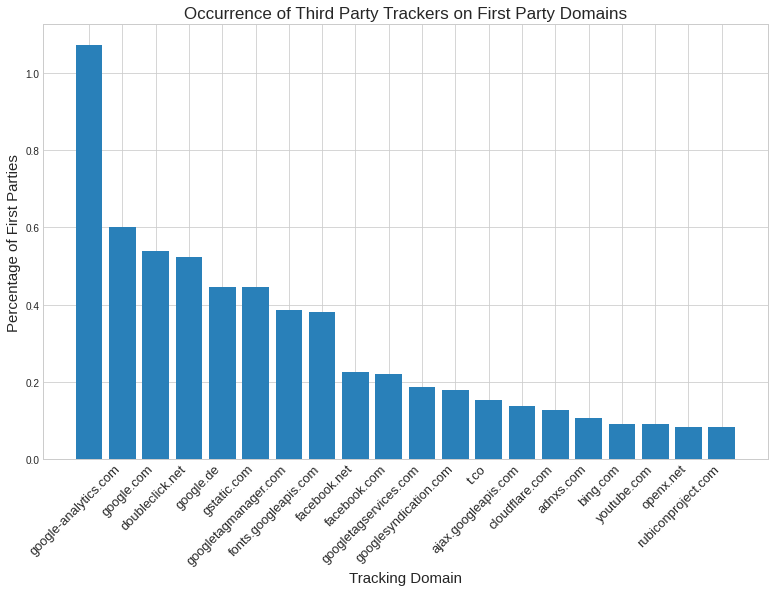

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')

x = domain_counts.domain[:20]
y = domain_counts.occ_percentage[:20]

x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize = (13,8))
plt.bar(x_pos, y, color = '#2980b9')
plt.xlabel("Tracking Domain", fontsize = 15)
plt.ylabel("Percentage of First Parties", fontsize = 15)
plt.title("Occurrence of Third Party Trackers on First Party Domains", fontsize = 17)

plt.xticks(x_pos, x, rotation=45, fontsize = 13, ha = "right")

plt.show()

## Combine Results of Tracking and Non-Tracking Realaed Occurrences of Tracking Domains

In [29]:
#merge together dataframes by host domain
domain_counts_final_df = domain_counts_tracking_identified.merge(domain_counts_residual_no_tracking, on="domain", how = 'inner')

#set column names
domain_counts_final_df.columns = ['domain', 'counts_tracking', 'occ_percentage_tracking', 'counts_no_tracking', 'occ_percentage_no_tracking']

#remove empty string domain
domain_counts_final_df = domain_counts_final_df[domain_counts_final_df.domain != '']

domain_counts_final_df[:10]

,domain,counts_tracking,occ_percentage_tracking,counts_no_tracking,occ_percentage_no_tracking
0,google-analytics.com,5510,0.593686,5573,0.600474
1,doubleclick.net,4723,0.508889,4861,0.523758
3,googletagmanager.com,2691,0.289947,3580,0.385734
4,google.com,2381,0.256546,4991,0.537765
5,googlesyndication.com,1653,0.178106,1653,0.178106
6,facebook.net,1634,0.176059,2082,0.224329
7,adnxs.com,892,0.096110,995,0.107208
8,bing.com,843,0.090831,847,0.091262
9,ioam.de,558,0.060123,598,0.064433
10,googleadservices.com,520,0.056028,529,0.056998


In [30]:
#calculate no tracking residuals
domain_counts_final_df['residuals'] = domain_counts_final_df['occ_percentage_no_tracking'] - domain_counts_final_df['occ_percentage_tracking']

#replace negative values by zero
domain_counts_final_df['residuals'][domain_counts_final_df['residuals'] < 0] = 0

#add column tracking percentage + residual percentage
domain_counts_final_df['ordering_plot'] = domain_counts_final_df['residuals'] + domain_counts_final_df['occ_percentage_tracking']

#reordering dataframe 
domain_counts_final_df = domain_counts_final_df.sort_values(by=['ordering_plot'], ascending=False)

domain_counts_final_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,domain,counts_tracking,occ_percentage_tracking,counts_no_tracking,occ_percentage_no_tracking,residuals,ordering_plot
0,google-analytics.com,5510,0.593686,5573,0.600474,0.006788,0.600474
4,google.com,2381,0.256546,4991,0.537765,0.281220,0.537765
1,doubleclick.net,4723,0.508889,4861,0.523758,0.014869,0.523758
398,google.de,1,0.000108,4136,0.445642,0.445534,0.445642
23,gstatic.com,221,0.023812,4127,0.444672,0.420860,0.444672
...,...,...,...,...,...,...,...
371,skyscnr.com,1,0.000108,1,0.000108,0.000000,0.000108
372,adledge.com,1,0.000108,1,0.000108,0.000000,0.000108
373,d2tycn7nnoiglw.cloudfront.net,1,0.000108,1,0.000108,0.000000,0.000108
375,clickiocdn.com,1,0.000108,1,0.000108,0.000000,0.000108


In [31]:
#prepare dataframe for plotting
domain_counts_final_plot_df = domain_counts_final_df[['domain', 'occ_percentage_tracking', 'residuals']][:20]

#column with tracking related percentage of occurrence
domain_counts_final_plot_df1 = domain_counts_final_plot_df[['domain', 'occ_percentage_tracking']]
domain_counts_final_plot_df1['context'] = 'tracking'

domain_counts_final_plot_df1.columns = ['domain', 'occ_percentage', 'context']

#column with non-tracking related residual percentage of occurrence
domain_counts_final_plot_df2 = domain_counts_final_plot_df[['domain', 'residuals']]
domain_counts_final_plot_df2['context'] = 'no tracking'

domain_counts_final_plot_df2.columns = ['domain', 'occ_percentage', 'context']

#concatenate data frames
domain_counts_final_plot_concat_df = pd.concat([domain_counts_final_plot_df1, domain_counts_final_plot_df2])

print(domain_counts_final_plot_df)
print(domain_counts_final_plot_concat_df)

                    domain  occ_percentage_tracking  residuals
0     google-analytics.com                 0.593686   0.006788
4               google.com                 0.256546   0.281220
1          doubleclick.net                 0.508889   0.014869
398              google.de                 0.000108   0.445534
23             gstatic.com                 0.023812   0.420860
3     googletagmanager.com                 0.289947   0.095787
6             facebook.net                 0.176059   0.048271
82            facebook.com                 0.003448   0.215925
67   googletagservices.com                 0.004525   0.181015
5    googlesyndication.com                 0.178106   0.000000
11                    t.co                 0.047732   0.103976
115         cloudflare.com                 0.002155   0.125094
7                adnxs.com                 0.096110   0.011098
8                 bing.com                 0.090831   0.000431
13             youtube.com                 0.037280   0

### Plot Final Results Together

Text(0, 0.5, 'Percentage of Occurrence on First Parties')

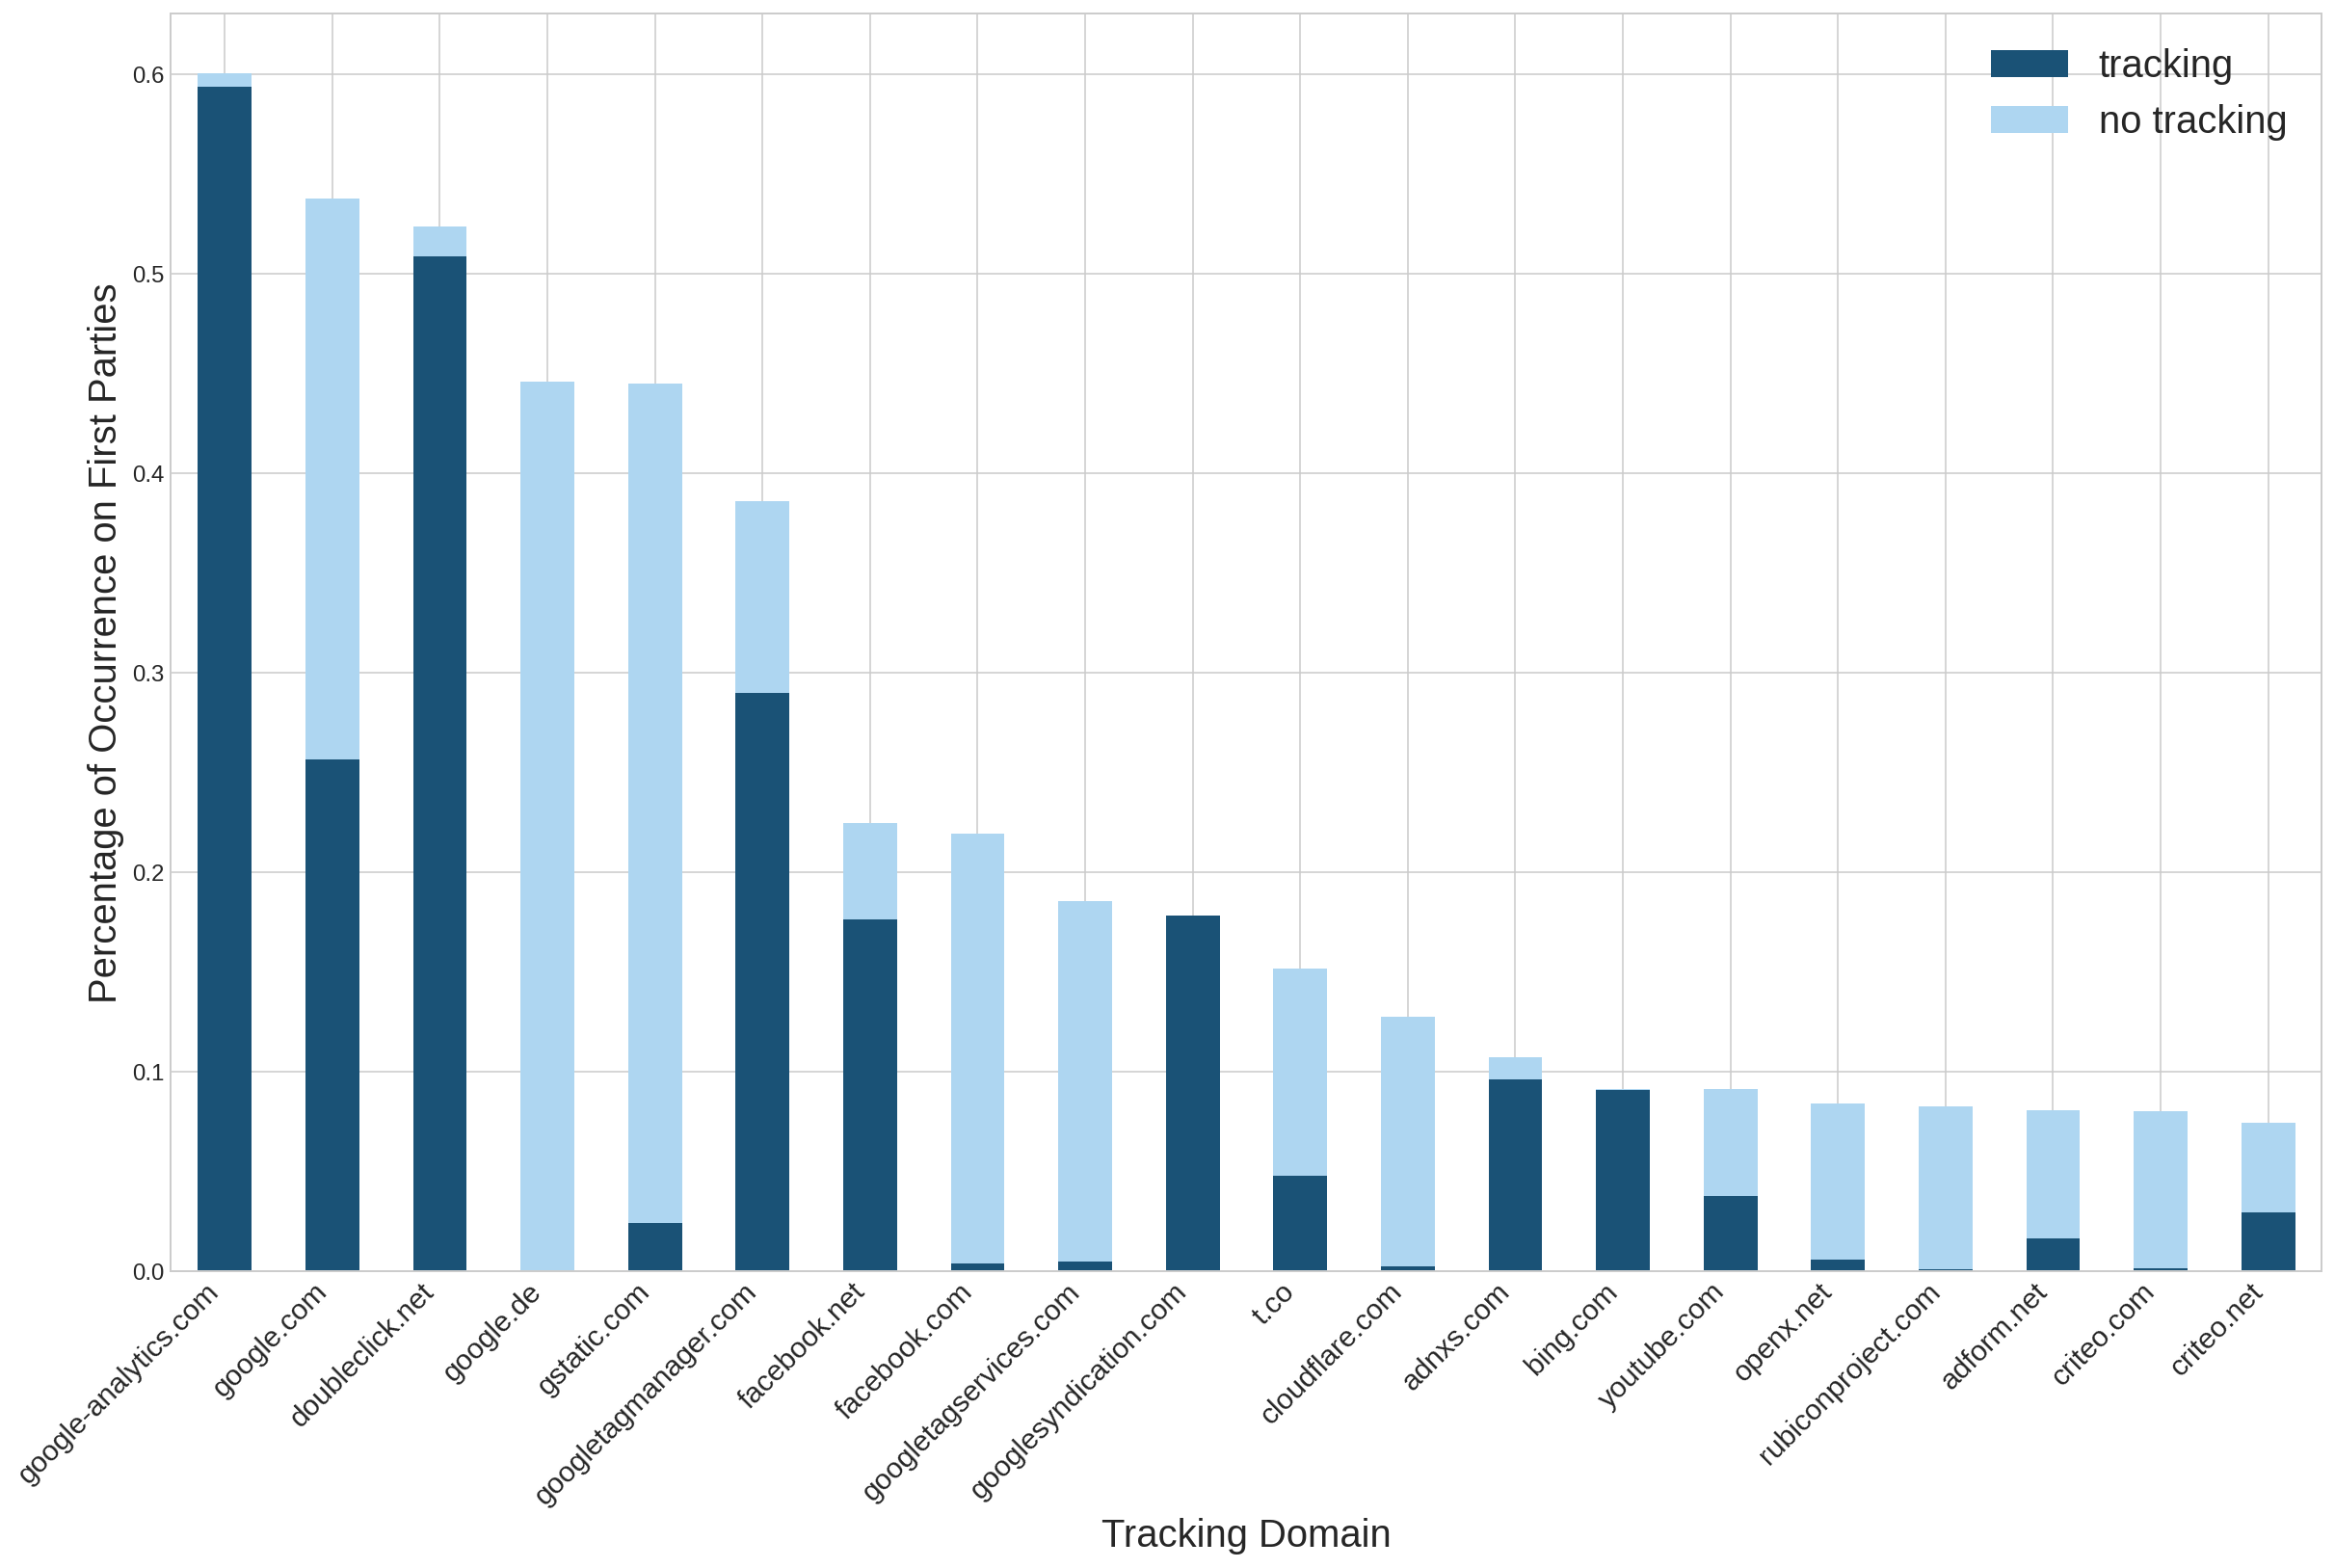

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#plotting stacked barchart
pivot_df = domain_counts_final_plot_concat_df.pivot(index='domain', columns='context', values='occ_percentage')
pivot_df['totals'] = pivot_df['no tracking'] + pivot_df['tracking']
pivot_df

pivot_df = pivot_df.reindex(pivot_df.sort_values(by='totals', ascending=False).index)
pivot_df

colors = ["#1A5276", "#AED6F1"]
plot = pivot_df.loc[:,['tracking', 'no tracking']].plot.bar(stacked=True, color=colors, figsize=(20,12), rot=45, fontsize='large')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize=15,
)
plt.legend(loc=1, prop={'size': 20})

plt.xlabel('Tracking Domain', fontsize=20)
plt.ylabel('Percentage of Occurrence on First Parties', fontsize=20)



In [0]:
fig = plot.get_figure()
fig.savefig("http_requests.pdf", bbox_inches='tight')